## Введение

Маркетологи везде. Иногда складывается ощущение, что никто не занимается производством, а все только лишь продают. Ощущение, отчасти, обманчивое поскольку маркетинг — это ремесло, где необходимо быть заметным, а сами маркетологи могут поднимать вокруг своей персоны огромное количество шума (как, например, [Торшина](https://torshina.me/)).

Но, только лишь отчасти внимание к маркетингу объясняется шумностью маркетологв. Это действительно огромная сфера сфера деятельности, которая в 2018 году [заняла 7% рынка вакансий по данным hh.ru](https://spb.hh.ru/article/503102).

Те, кого мы привыкли объединять словом «маркетологи» — представляют из себя довольно разношёрстную компанию. Сюда входят и PR-специалисты, которые формируют имидж человека или компании, интернет-маркетологи, из-за которых мы видим рекламу на сайтах, криэйторы, придумывающие «креативы», SEOшникии, SMMщики и ещё более специфические породы.
<div class="note">
<blockquote class="blockquote">
<p>— Пойдёшь ко мне в штат?</p>
<p>Татарский ещё раз посмотрел на плакат с тремя пальмами и англоязычным обещанием вечных метаморфоз.</p>
<p>— Кем? — спросил он.</p>
<p>— Криэйтором.</p>
<p>— Это творцом? — переспросил Татарский. — Если перевести?</p>
<p>Ханин мягко улыбнулся.</p>
<p>— Творцы нам тут на хуй не нужны, — сказал он. — Криэйтором, Вава, криэйтором.</p>
  <footer class="blockquote-footer">Пелевин, <cite title="Source Title">Generation «П»</cite></footer>
</blockquote>
</div>

Но всё-таки в своём первоначальном значении маркетолог — это специалист, занимающийся анализом рынка. Рынок, как известно, составляют спрос и предложение, и маркетолога больше всего интересует первая составляющая рынка — спрос. Сегодня мы рассмотрим типичное задание для специалиста по анализу данных в маркетинге.

Исходные данные:
* Собраны данные по некоторой мобильной игре.
* Платформа iOS.
* Один источник трафика - крупная видеосеть.
* Период один месяц. 01.09-30.09.
* [Таблица с установками по источнику](/datasets/marketing1/installs.csv)
* [Таблица с платежами по источнику](/datasets/marketing1/payments.csv)

Задание:
* Определить окупилась ли кампания.
* Каких сабпаблишеров* стоит отключить, а на каких поднять ставку? (Сабпаблишером является уникальный “Site ID” в рамках уникального “Campaign”.)
* Построить кривую LTV и спрогнозировать значение на 2 месяца вперед.
* Проверить гипотезы: iPhone платит лучше iPad; iPhone X самый платящий девайс.

Ответы необходимо представить в виде отчета с необходимыми выводами и графиками.

## EDA

Первый шаг в любом анализе — разведка. Взглянем на основные признаки и попробуем понять структуру данных.

Для этого вначале импортируем необходимые библиотеки и загрузим данные. Я буду использовать Python и его пакеты.

In [541]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_columns = 100

date_cols = ["Attributed Touch Time", "Install Time", "Event Time"]
installs = pd.read_csv("https://nagornyy.me/datasets/marketing1/installs.csv",
                       sep="\t", parse_dates=date_cols)
payments = pd.read_csv("https://nagornyy.me/datasets/marketing1/payments.csv",
                       sep="\t", parse_dates=date_cols)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (36,42,43,44,45,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [542]:
installs.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue USD,Event Source,Is Receipt Validated,Partner,Channel,Keywords,Campaign,Campaign ID,Adset,Adset ID,Ad,Ad ID,Ad Type,Site ID,Sub Site ID,Sub Param 1,Sub Param 2,Sub Param 3,Sub Param 4,Sub Param 5,Cost Model,Cost Value,Cost Currency,Contributor 1 Partner,Contributor 1 Media Source,Contributor 1 Campaign,Contributor 1 Touch Type,Contributor 1 Touch Time,Contributor 2 Partner,Contributor 2 Media Source,Contributor 2 Campaign,Contributor 2 Touch Type,Contributor 2 Touch Time,Contributor 3 Partner,Contributor 3 Media Source,Contributor 3 Campaign,Contributor 3 Touch Type,Contributor 3 Touch Time,Region,Country Code,State,City,Postal Code,DMA,IP,WIFI,Operator,Carrier,Language,AppsFlyer ID,IMEI,Platform,Device Type,OS Version,App Version,SDK Version,App ID,App Name,Bundle ID,Is Retargeting,Retargeting Conversion Type,Attribution Lookback,Reengagement Window,Is Primary Attribution,User Agent,HTTP Referrer,Original URL,Install App Store,Match Type,Contributor 1 Match Type,Contributor 2 Match Type,Contributor 3 Match Type,Device Category,Google Play Referrer,Google Play Click Time,Google Play Install Begin Time
0,click,2018-09-30 23:42:00,2018-09-30 23:56:00,2018-09-30 23:56:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1550428,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.60,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,AT,9,Vienna,1100,None,84.113.35.31,True,NaN,NaN,de-AT,1538347375900-8545045,NaN,ios,iPad Air 2,12,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/974.2.1 Darwin/18.0.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,tablet,NaN,NaN,NaN
1,click,2018-09-30 09:15:00,2018-09-30 23:50:00,2018-09-30 23:50:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2718129,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,UK,OXF,Abingdon,ox13 5jb,826045,37.60.86.18,True,NaN,NaN,en-GB,1538291762135-7959619,NaN,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
2,click,2018-09-24 15:23:00,2018-09-30 23:49:00,2018-09-30 23:49:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_AGM_8_NO_Sound_europe,NaN,NaN,1550428,NaN,NaN,NaN,NaN,NaN,NaN,cpi,0.55,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,BE,BRU,Brussels,None,None,109.130.165.97,True,NaN,NaN,fr-BE,1537799053703-9915353,NaN,ios,iPhone X,12,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,NaN,ageofmagic/3 CFNetwork/974.2.1 Darwin/18.0.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
3,impression,2018-09-30 13:08:00,2018-09-30 23:47:00,2018-09-30 23:47:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_FR,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.74,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,FR,OCC,Perpignan,66000,250066,5.48.50.147,True,NaN,NaN,fr-FR,1538345877931-2516524,NaN,ios,iPhone 8,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,1d,NaN,NaN,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://impression.appsflyer.com/id1175370741?...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
4,click,2018-09-30 23:05:00,2018-09-30 23:41:00,2018-09-30 23:41:00,install,NaN,NaN,NaN,NaN,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1458550,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E

В таблице содержатся данные о 13098 установках и 84 признаках:

In [543]:
installs.shape

(13098, 84)

Как видно, многие переменные довольно бессмысленны — они или содержат только пропущенные значения или или заполнены лишь одним ненулевым значением. Доля непустых значений в переменной находится в колонке `Filled share`, а количество уникальных значение в колонке `N unique`.

In [544]:
pd.DataFrame({
    "Filled share": ((~installs.isnull()).sum() / len(installs)).round(2),
    "N unique": installs.nunique()
}).head()

,Filled share,N unique
Attributed Touch Type,1.0,2
Attributed Touch Time,1.0,10476
Install Time,1.0,10723
Event Time,1.0,10723
Event Name,1.0,1


Похожим образом обстоят дела и с таблицей payments, где содержится информация ровно об одном типе событий — внутриигровых покупках. Разумеется, её размер меньше предыдущей таблицы, поскольку не все пользователи, установившие приложение, дошли до этапа покупки.

In [545]:
payments.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue USD,Event Source,Is Receipt Validated,Partner,Channel,Keywords,Campaign,Campaign ID,Adset,Adset ID,Ad,Ad ID,Ad Type,Site ID,Sub Site ID,Sub Param 1,Sub Param 2,Sub Param 3,Sub Param 4,Sub Param 5,Cost Model,Cost Value,Cost Currency,Contributor 1 Partner,Contributor 1 Media Source,Contributor 1 Campaign,Contributor 1 Touch Type,Contributor 1 Touch Time,Contributor 2 Partner,Contributor 2 Media Source,Contributor 2 Campaign,Contributor 2 Touch Type,Contributor 2 Touch Time,Contributor 3 Partner,Contributor 3 Media Source,Contributor 3 Campaign,Contributor 3 Touch Type,Contributor 3 Touch Time,Region,Country Code,State,City,Postal Code,DMA,IP,WIFI,Operator,Carrier,Language,AppsFlyer ID,Platform,Device Type,OS Version,App Version,SDK Version,App ID,App Name,Bundle ID,Is Retargeting,Retargeting Conversion Type,Attribution Lookback,Reengagement Window,Is Primary Attribution,User Agent,HTTP Referrer,Original URL,Install App Store,Match Type,Contributor 1 Match Type,Contributor 2 Match Type,Contributor 3 Match Type,Device Category,Google Play Referrer,Google Play Click Time,Google Play Install Begin Time
0,click,2018-09-30 23:33:00,2018-09-30 23:35:00,2018-09-30 23:52:00,af_purchase,"{""af_revenue"":""1.99"",""af_currency"":""GBP"",""af_q...",1.99,GBP,2.595963,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,UK,BST,Bristol,bs4 1aa,826047,92.234.108.92,True,NaN,NaN,en-GB,1538343242930-8513482,ios,iPhone 8,11.4,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/901.1 Darwin/17.6.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
1,click,2018-09-23 21:01:00,2018-09-24 16:21:00,2018-09-30 23:36:00,af_purchase,"{""af_revenue"":""8.99"",""af_currency"":""EUR"",""af_q...",8.99,EUR,10.450791,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1527921,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.00,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,ES,B,Barcelona,8024,None,93.176.147.87,True,NaN,NaN,es-ES,1537732876768-5561101,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
2,click,2018-09-23 21:01:00,2018-09-24 16:21:00,2018-09-30 23:33:00,af_purchase,"{""af_revenue"":""7.99"",""af_currency"":""EUR"",""af_q...",7.99,EUR,9.288300,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_WW,NaN,NaN,NaN,AOM_Appstore_01_En+V,NaN,NaN,1527921,NaN,NaN,NaN,NaN,NaN,NaN,cpi,2.00,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EU,ES,B,Barcelona,8024,None,93.176.147.87,True,NaN,NaN,es-ES,1537732876768-5561101,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
3,click,2018-09-26 14:32:00,2018-09-26 15:00:00,2018-09-30 23:14:00,af_purchase,"{""af_revenue"":""40"",""af_currency"":""CNY"",""af_qua...",40.00,CNY,5.823179,SDK,NaN,NaN,NaN,NaN,AOM_2018_test_1_CN,NaN,NaN,NaN,AOM_CN_TR+V,NaN,NaN,2731992,NaN,NaN,NaN,NaN,NaN,NaN,cpi,3.50,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AS,CN,HB,Jingmen,448000,156175,113.57.183.59,False,NaN,NaN,en-CN,1537990383550-7399746,ios,iPhone 7 Plus,11.4.1,1.7.4,v4.8.7,id1175370741,Age Of Magic,com.playkot.ageofmagic,False,NaN,7d,NaN,True,ageofmagic/3 CFNetwork/902.2 Darwin/17.7.0,NaN,https://app.appsflyer.com/id1175370741?pid=uni...,NaN,id_matching,NaN,NaN,NaN,phone,NaN,NaN,NaN
4,click,2018-09-26 06:01:00,2018

In [546]:
payments.shape

(5622, 83)

In [547]:
pd.DataFrame({
    "Filled share": ((~payments.isnull()).sum() / len(payments)).round(2),
    "N unique": payments.nunique()
}).head()

,Filled share,N unique
Attributed Touch Type,1.0,2
Attributed Touch Time,1.0,1434
Install Time,1.0,1435
Event Time,1.0,5013
Event Name,1.0,1


Посмотрим, какие переменные есть в таблице установок, но нет в таблице платежей и наоборот.

In [548]:
set(payments.columns) ^ set(installs.columns)

{'IMEI'}

Только одна уникальная переменная присутствует в таблице установок — `IMEI`, но она абсолютно бесполезна, поскольку содержит лишь пустые значения.

## Определить окупилась ли кампания

Ответим на первый вопрос задания, а именно, окупилась ли рекламная кампания. Рекламная компания представляет собой систему мероприятий, направленных на определённую аудиторию и использующих определённые площадки. В нашем случае, площадками являются сайты, а кампании направлены на аудиторию разных регионов. Видимо, названия кампания расшифровываются следующим образом: World Wide (`AOM_2018_test_1_WW`), China (`AOM_2018_test_1_CN` и `AOM_2018_test_1_CN_WL_2`), United States (`AOM_2018_test_1_US`), France (`AOM_2018_test_1_FR`), Denmark (`AOM_2018_test_1_DE`) и т.д.

Для рассчёта окупаемости кампании воспользуемся известным показателем окупаемости — Return on Investment. ROI рассчитывается следующим образом: $\frac{Gain \ from \ Investment - Cost \ of \ Investment}{Cost \ of \ Investment}$

Показатель *Gain from Investment* можно узнать из переменной `Event Revenue USD` (стоимость внутриигровой покупки, которую сделал пользователь), а о *Cost of Investment* может сказать переменная `Cost Value` (стоимость привлечения нового пользователя).

Итак, начнём. Сразу бросается в глаза, что в таблице c установками содержится информация о меньшем количестве кампаний, чем в таблице с платежами. Это может быть по разным причинам, но в данном случае не существенно.

In [549]:
gain = payments.groupby("Campaign")["Event Revenue USD"].sum().sort_values()
cost = installs.groupby("Campaign")["Cost Value"].sum()

roi = (gain - cost) / cost * 100
roi.sort_values(ascending=False)

Campaign
AOM_2018_test_1_CN            93.271509
AOM_2018_test_1_WW            27.738407
AOM_2018_test_1_DE            14.945392
AOM_2018_test_1_CN_WL_2       -7.796267
AOM_2018_test_1_FR           -22.881215
AOM_2018_test_1_US           -38.406292
AOM_2018_test_1_CA                  NaN
AOM_2018_test_CN_Retention          NaN
AOM_2018_test_CN_WL                 NaN
dtype: float64

Выводы: 
* Для кампаний `AOM_2018_test_1_CA`, `AOM_2018_test_CN_Retention` и `AOM_2018_test_CN_WL` невозможно посчитать ROI, поскольку неизвестны затраты на привлечение пользователей в рамках этих кампаний (отсутствуют в таблице с установками).
* Из оставшихся шести кампаний три прибыльные (`AOM_2018_test_1_CN`, `AOM_2018_test_1_WW` и `AOM_2018_test_1_DE`), а три остальные убыточные.
* Наиболее прибыльная кампания — `AOM_2018_test_1_CN` ($ROI=93.3\%$), наиболее убыточная — `AOM_2018_test_1_US` ($ROI=-38.4\%$).

## Прибыльность сабпаблишеров
**Каких сабпаблишеров стоит отключить, а на каких поднять ставку? Сабпаблишером является уникальный `Site ID` в рамках уникального `Campaign`.**

В качестве индикатора прибыльности сабпаблишера будем использовать CPI — отношение бюджета рекламной кампании к количеству установок приложения. Будем использовать простейшую стратегию: если CPI маленький — повышаем ставку, чтобы её предельная полезность была максимальная, если слишком большой — отключаем.

Причем, необходимо считать CPI для каждого сабпаблишера в каждой кампании, поскольку они могут пересекаться. Да и в целом логично предположить, что сабпаблишер, который принёс мало установок в рамках одной кампании, покажет совершенно другой результат в рамках другой, потому что в первом случае кампания могла не попасть в аудиторию сабпаблишера.

In [550]:
installs_groupby = installs.groupby(["Campaign", "Site ID"])

ad_cost_by_site_and_campaign = installs_groupby["Cost Value"].sum()
num_install_by_site_and_campaign = installs_groupby.size()

cpi = ad_cost_by_site_and_campaign / num_install_by_site_and_campaign

In [551]:
cpi.head()

Campaign            Site ID
AOM_2018_test_1_CN  11481      3.5
                    12723      3.5
                    14328      3.5
                    14612      3.5
                    15189      3.5
dtype: float64

Итак, CPI для каждого сабпаблишера в каждой кампании рассчитан. Взглянем на распределение:

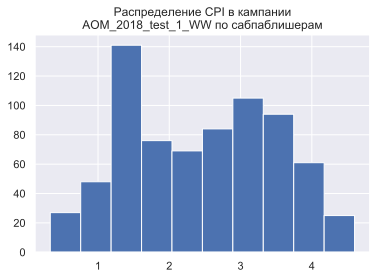

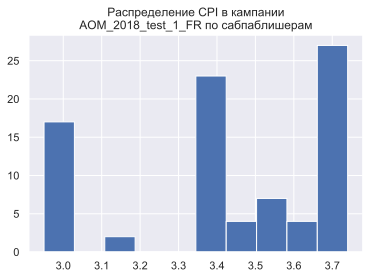

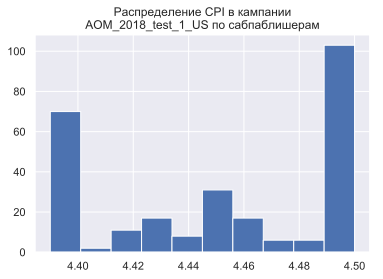

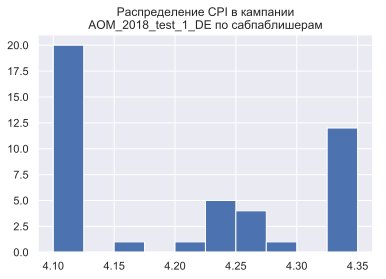

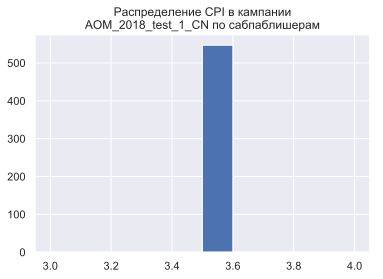

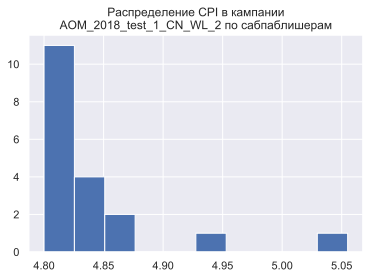

In [552]:
for campaign in installs.Campaign.unique():
    plt.figure()
    plt.title(f"Распределение CPI в кампании\n{campaign} по сабпаблишерам")
    cpi.loc[campaign].hist();

Только в кампании `AOM_2018_test_1_WW` распределение более-менее похоже на нормальное. Самый странный случай — кампания `AOM_2018_test_1_CN`, в которой все сабпаблишеры имеют одинаковый CPI. Спишем такие аномалии на особенности выборки для задания — кажется, она была не случайной.

Из-за таких аномалий стратегию ставок для каждой кампании стоит считать отдельно. В кампании `AOM_2018_test_1_WW` я бы отключил сабпаблишеров, которые находятся в нижнем дециле и повысил ставки у сабпаблишеров из верхнего дециля.

In [553]:
first_decile = cpi.loc["AOM_2018_test_1_WW"].quantile(.10)
last_decile = cpi.loc["AOM_2018_test_1_WW"].quantile(.90)
print(f"Исключаем, если CPI ниже {first_decile}, повышаем ставки, если CPI выше {last_decile}")

Исключаем, если CPI ниже 1.1738205128205128, повышаем ставки, если CPI выше 3.9


In [554]:
raise_rates_WW = cpi.loc["AOM_2018_test_1_WW"][cpi.loc["AOM_2018_test_1_WW"] > last_decile]
exclude_WW = cpi.loc["AOM_2018_test_1_WW"][cpi.loc["AOM_2018_test_1_WW"] < first_decile]

# сохраним список сабпаблишеров, которых следует исключить и которым надо повысить ставки
raise_rates_WW.to_excel("output/raise_rates_WW.xlsx")
exclude_WW.to_excel("output/exclude_WW.xlsx")

В остальных кампаниях разброс значений CPI для разных сабпаблишеров не сильно велик (например, в кампании `AOM_2018_test_1_US` разница между паблешерами с самым низким и самым высоким CPI составляет одну десятую, а в `AOM_2018_test_1_CN` вообще у всех CPI одинаков), поэтому я бы не стал выносить решение об исключении или повышении ставок до тех пор, пока в моём распоряжении не будет полная выборка.

## Построить кривую LTV и спрогнозировать значение на 2 месяца вперед.
«Кривая LTV – L(t) – это функция, отражающая средний доход с игрока в зависимости от времени с момента регистрации. Например, если за месяц с момента регистрации пользователи в среднем приносят по \$2,55, то говорят, что «LTV 30 равен 2,55». То есть L (30) = 2,55».

Для рассчёта LTV нам нужны следующие переменные:
* дата установки приложения `Install Time`
* даты платежей пользователей `Event Time`
* сумма платежа `Event Revenue USD`
* идентификатор пользователя — с этим сложнее. Можно подумать, что идентификатором пользователя можно считать поле `IP`, но, [если я всё правильно понял](https://dtf.ru/promo/13693-appsflyer), более точно идентифицурует пользователя поле `AppsFlyer ID`.

Теперь непосредственно про построение LTV — её можно построить [разными способами](https://habr.com/ru/post/292312/), для самого простого из которых достаточно «весь доход приложения за период разделить на общее количество пользователей за тот же период». Но это не наш путь, ведь итоговая цель — построение прогнозной модели.

В нашем случае LTV будет рассчитваться частное от кумулятивной суммы покупок пользователей и кумулятивного количества этих пользователей за разные промежутки времени:

In [575]:
ltv = payments[["AppsFlyer ID", "Install Time", "Event Time", "Event Revenue USD"]].copy()
ltv["install_date"] = ltv["Install Time"].dt.round("D")
ltv["purchase_date"] = ltv["Event Time"].dt.round("D")

def get_cum_sum(date):
    return ltv['Event Revenue USD'].where(ltv['purchase_date']<=date).sum()

ltv['cum_sum'] = ltv['purchase_date'].map(lambda x: get_cum_sum(x))

def get_users_cumcount(date):
    return ltv["AppsFlyer ID"].where(ltv['install_date'] <=date).count()

ltv['users_cum_count'] = ltv['purchase_date'].map(lambda x: get_users_cumcount(x))
ltv['ltv'] = ltv['cum_sum'] / ltv['users_cum_count']
ltv['day'] = pd.to_timedelta(ltv['purchase_date'] - ltv['install_date'].min()).dt.days + 1

In [576]:
ltv_forecast = ltv.drop_duplicates(subset=["cum_sum", "day"])

Text(0, 0.5, 'LTV')

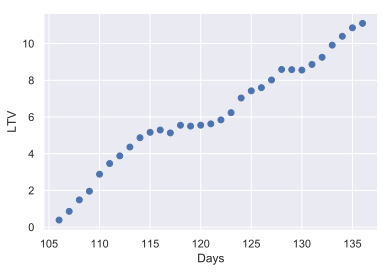

In [577]:
plt.scatter(ltv_forecast['day'], ltv_forecast['ltv'])
plt.xlabel('Days')
plt.ylabel('LTV')

На данном графике по оси X отложено количество дней, прошедших с момента установки приложения до момента совершения первой покупки, а по оси Y — LTV. Видно, что чем больше дней проходит, тем выше LTV.

Спрогнозируем его будущие значения на 60 дней вперёд при помощи авторегрессионной модели ARIMA первого пордка по всем компонентам (по хорошему надо протестировать разные модели, но это всё-таки только тестовое задание).

Функция автокорреляции показывает наличие корреляции первого и второго порядков, так что можно ожидать неплохой модели.

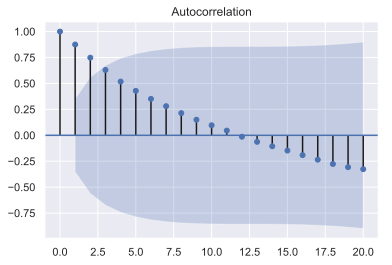

In [583]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ltv_forecast.ltv, lags=20);

In [584]:
ts_ltv = pd.Series(data=ltv_forecast.ltv.values, index=ltv_forecast.day.values).sort_index()

In [594]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_ltv, order=(2,1,1)); # просто модель
model_fit = model.fit();

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Предсказываем на 60 дней вперёд

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


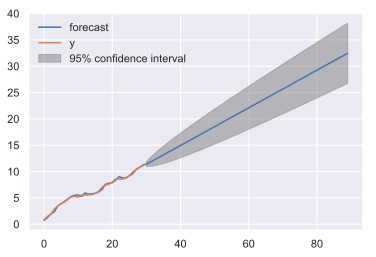

In [595]:
model_fit.plot_predict(end=90);

Для анализа LTV можно также воспользоваться пакетом [**lifetimes**](https://github.com/CamDavidsonPilon/lifetimes). Он содержит множество модулей для работы с LTV и постоянно развивается. Lifetimes позволяет производить разные виды анализа — предсказывать, вероятность того, что пользователь вернётся, исходя из его поведения в будущем, рассчитать вероятное количество покупок пользователя в следующий период и т.д. Вот, например, вероятность возвращения пользователя:

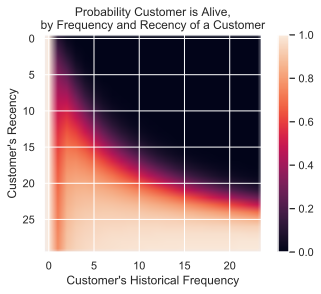

In [574]:
import lifetimes as lt

ltv_summary = lt.utils.summary_data_from_transaction_data(ltv, 'AppsFlyer ID', 'Event Time', monetary_value_col='Event Revenue USD')
bgf = lt.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(ltv_summary['frequency'], ltv_summary['recency'], ltv_summary['T'])

lt.plotting.plot_probability_alive_matrix(bgf);

## Проверить гипотезы: iPhone платит лучше iPad; iPhone X самый платящий девайс

Самый простой способ способ проверить эти гипотезы — построить графики. Зачастую, всё будет понятно из них.

### iPhone платит лучше iPad

Начнём с первой гипотезы и для начала построим круговые диаграммы, отражающие количество девайсов каждого вида и средний платёж их владельцев.

In [539]:
def iphone_ipad(device: str):
    for apple_device in ["iphone", "ipad"]:
        if apple_device in device.lower():
            return apple_device

payments["iphone_ipad"] = payments["Device Type"].apply(iphone_ipad)

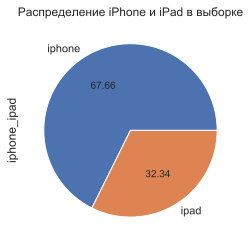

In [540]:
plt.title("Распределение iPhone и iPad в выборке")
payments["iphone_ipad"].value_counts().plot(kind="pie", autopct='%.2f');

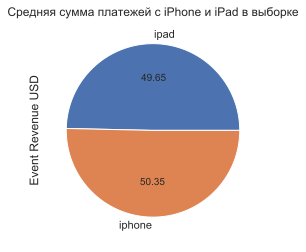

In [383]:
plt.title("Средняя сумма платежей с iPhone и iPad в выборке")

payments[["iphone_ipad", "Event Revenue USD"]] \
    .groupby("iphone_ipad").mean()["Event Revenue USD"].plot(kind="pie", autopct='%.2f');

Видим, что средняя сумма платежей весьма близка. Простой графический анализ в этом случае не поможет ответить на вопрос, а вот t-test поможет. t-test — это тест, который проверяет гипотезу о равенстве средних в двух выборках. В нашем случае это будут средние платежи владельцев iPhone и iPad. Но как и любой статистический тест, он имеет некоторые ограничения — распределение в выборках должно быть нормальным, и их дисперсии не должны сильно отличаться.

In [394]:
iphone_revenue = payments.query("iphone_ipad == 'iphone'")["Event Revenue USD"]
ipad_revenue = payments.query("iphone_ipad == 'ipad'")["Event Revenue USD"]

Проверим, сильно ли различаются дисперсии:

In [395]:
iphone_revenue.var(), ipad_revenue.var()

(318.4126246777497, 326.6367213821259)

Даже на глаз видно, что не сильно. Тогда посмотрим на распределение:

(<matplotlib.axes._subplots.AxesSubplot at 0x12cc4bac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cc4bac8>)

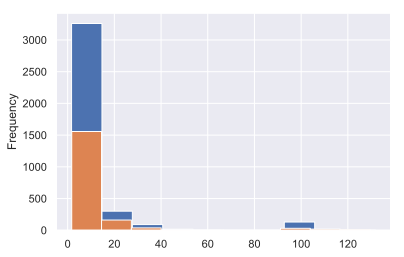

In [401]:
iphone_revenue.plot(kind="hist"), ipad_revenue.plot(kind="hist")

Распределение явно не нормальное — следствие всё той же неплоной выборки. Попробуем логарифмировать, а если не поможет — применим трансформацию Бокса-Кокса.

(<matplotlib.axes._subplots.AxesSubplot at 0x12c08d080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c08d080>)

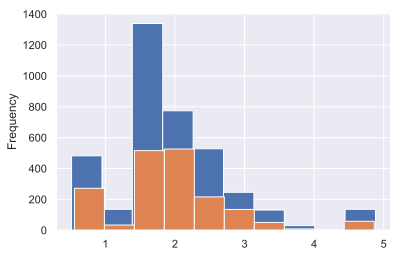

In [403]:
np.log(iphone_revenue).plot(kind="hist"), np.log(ipad_revenue).plot(kind="hist")

Да, логарифмирование сделало распределение более-менее нормальным. По крайнем мере, вряд ли на такой выборке удатся добиться чего-то сильно лучшего.

Время применять t-test:

In [404]:
from scipy.stats import ttest_ind

ttest_ind(iphone_revenue, ipad_revenue)

Ttest_indResult(statistic=0.30342072693291366, pvalue=0.7615804833690807)

p-value показывает вероятность того, что нулевая гипотеза о равенстве средних верна. В нашем случае p-value намного больше 0.05, поэтому мы не можем утверждать, что средние цены не равны. Следовательно **ответ: различие в платежах с iPhone и iPad статистически не значимо, нельзя сказать, что iPhone платит лучше iPad**.

### iPhone X самый платящий девайс
Начнём с перейдём ко второй гипотезе. Посмотрим на распределение среднего количество платежей по девайсу:

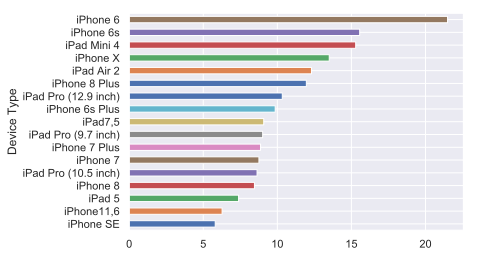

In [380]:
payments.groupby("Device Type")["Event Revenue USD"].mean().sort_values(ascending=True).plot.barh();

Весьма странная картина — с чего бы владельцам уже сильно устаревшего iPhone 6 быть самыми платежеспособными? Возможно, распределение количества устройств поможет дать ответ.

In [378]:
payments["Device Type"].value_counts(ascending=True)

iPhone 6                   1
iPhone SE                  2
iPhone11,6                 2
iPad7,5                   48
iPad Pro (9.7 inch)      121
iPhone 8                 160
iPhone 6s Plus           207
iPad 5                   231
iPad Pro (10.5 inch)     269
iPhone 6s                282
iPad Pro (12.9 inch)     283
iPad Mini 4              289
iPhone 8 Plus            482
iPad Air 2               577
iPhone 7                 637
iPhone 7 Plus            898
iPhone X                1133
Name: Device Type, dtype: int64

Теперь всё ясно — дело в очень перекошеной выборке. **В наборе данных имеется всего один человек с iPhone 6, и да — он платит больше, чем владельцы остальных устройств в среднем. Однако, на такой выборке нельзя делать статистически значимых выводов, на ней невозможно оценить ошибку. Для корректного ответа на поставленный вопрос я бы попросил полную выборку данных.**

## Выводы

**Определить окупилась ли кампания**

* Для кампаний `AOM_2018_test_1_CA`, `AOM_2018_test_CN_Retention` и `AOM_2018_test_CN_WL` невозможно посчитать ROI, поскольку неизвестны затраты на привлечение пользователей в рамках этих кампаний (отсутствуют в таблице с установками).
* Из оставшихся шести кампаний три прибыльные (`AOM_2018_test_1_CN`, `AOM_2018_test_1_WW` и `AOM_2018_test_1_DE`), а три остальные убыточные.
* Наиболее прибыльная кампания — `AOM_2018_test_1_CN` ($ROI=93.3\%$), наиболее убыточная — `AOM_2018_test_1_US` ($ROI=-38.4\%$).

**Каких сабпаблишеров* стоит отключить, а на каких поднять ставку?**

Список предполагаемых сабпаблишеров для кампании AOM_2018_test_1_WW находится в файлах `output/raise_rates_WW.xlsx` и `output/exclude_WW.xlsx`. Для принятия решения по поводу остальных компаний мало данных.

**Построить кривую LTV и спрогнозировать значение на 2 месяца вперед**

Сделано при помощи модели ARIMA.

**Проверить гипотезы: iPhone платит лучше iPad; iPhone X самый платящий девайс.**

iPhone платит лучше iPad — различие в платежах с iPhone и iPad статистически не значимо, нельзя сказать, что iPhone платит лучше iPad.

iPhone X самый платящий девайс — нельзя утверждать однозначно, малый размер выборки.